# Ellipse calculations

## Imports

In [1]:
# Python standard library
import sys
import csv


# Scientific computing
import numpy as np
import cv2
import matplotlib.pyplot as plt
import scipy.ndimage
import scipy.interpolate
#import seaborn as sns


# Program specific
sys.path.append('/home/prestonh/Desktop/Research/pore_stats/pore_stats/rp/')
sys.path.append('/home/prestonh/Desktop/Research/pore_stats/pore_stats/oi/')
import resistive_pulse as rp
import rp_file
import optical_imaging as oi
import oi_file


# Jupyter
from IPython.display import HTML

## Constants

In [2]:
save_data = True
save_plot = True

nm = 10**(-9.)
um = 10**(-6.)

## Load video and events

In [8]:
date = '10-10-2017/'
particle = '293-T_0/'
channel = '10-20-10_3/'
file_index = '0'

base_path = '/home/prestonh/Desktop/Research/cancer_cells/data/'

oi_vid_file_path = base_path + date + particle + channel + 'oi/bin/test_camera_' + file_index
oi_events_file_path = base_path + date + particle + channel + 'oi/events/test_camera_' + file_index + '_events.json'


res_x = 384
res_y = 112
fps = 250000.
exposure_time = .5*10**(-6.)

In [4]:
# Load video
oi_vid = oi_file.Video(oi_vid_file_path, res_x, res_y, fps)

# Load events
oi_events = oi_file.open_event_file_json(oi_events_file_path)

/home/prestonh/Desktop/Research/pore_stats/pore_stats/oi/optical_imaging.py:75: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if pixels != None:


## Output

In [10]:
save_base_path = '/home/prestonh/Desktop/Research/cancer_cells/analysis/data/' + date + particle + channel + file_index

print save_base_path

/home/prestonh/Desktop/Research/cancer_cells/analysis/data/10-10-2017/293-T_0/10-20-10_3/0


# Create stage

[ 0.02707341  0.99963345]


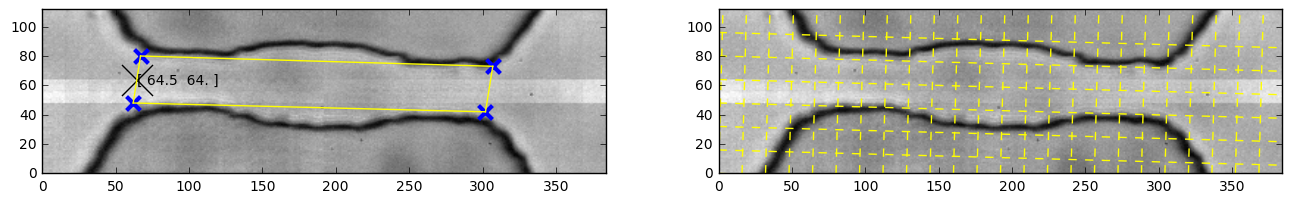

In [9]:
reload(oi)
template_frame = oi_vid.get_frame(template_index)

stage_file_path = base_path + date + particle + channel + 'oi/stage/stage_' + file_index
cs = oi.load_stage_file(stage_file_path)

c0 = cs[0]
c1 = cs[1]
c2 = cs[2]
c3 = cs[3]

oi_stage = oi.Stage(template_frame, c0, c1, c2, c3)
oi_stage.plot_stage()

## Load ellipses

In [12]:
oi_ellipse_base_path = '../data/'
oi_ellipse_path = oi_ellipse_base_path + date + particle + channel + file_index + '/ellipses'

ellipsess = []


with open(oi_ellipse_path, 'r') as file_handle:
    file_reader = csv.reader(file_handle, delimiter = '\t')
    
    # Skip header
    header_length = 2
    for i in range(header_length):
        next(file_reader)
        
        
    for row in file_reader:
        
        if row[0] == 'event #':
            # New event
            ellipsess.append([])
            continue
            
        else:
            ellipse = []
            for ele in row:
                try:
                    ellipse.append(float(ele))
                except:
                    ellipse.append(0)
                    
            ellipsess[-1].append(ellipse)

## Filter

In [14]:
# Load keep indices
filter_file_path = '../data/' + date + particle + channel + file_index + '/filter'

with open(filter_file_path, 'r') as filter_file_handle:
    filter_file_reader = csv.reader(filter_file_handle, delimiter = '\t')
    for row in filter_file_reader:
        if row[0] == 'events':
            keep_indices = [int(ele) for ele in row[1:]]

print 'loaded keep indices (', len(keep_indices), 'events total):\n', keep_indices
filtered_oi_events = [oi_events[i] for i in range(len(oi_events)) if i in keep_indices]
filtered_ellipsess = [ellipsess[i] for i in range(len(ellipsess)) if i in keep_indices]

loaded keep indices ( 222 events total):
[4, 8, 14, 18, 22, 35, 50, 57, 65, 70, 80, 82, 93, 101, 117, 134, 135, 153, 162, 173, 182, 186, 189, 192, 205, 206, 208, 210, 224, 226, 230, 236, 246, 250, 251, 255, 258, 262, 266, 271, 278, 279, 281, 317, 319, 326, 328, 329, 333, 334, 336, 344, 346, 350, 355, 360, 369, 375, 379, 382, 384, 390, 404, 417, 427, 430, 433, 441, 447, 451, 456, 474, 483, 495, 501, 514, 516, 525, 538, 542, 550, 554, 557, 562, 567, 574, 575, 583, 584, 595, 605, 606, 607, 614, 620, 621, 622, 623, 624, 639, 664, 689, 695, 701, 702, 703, 711, 719, 723, 733, 740, 741, 743, 755, 756, 759, 764, 767, 769, 776, 786, 787, 791, 793, 796, 803, 804, 807, 814, 823, 827, 829, 843, 848, 875, 876, 877, 880, 881, 890, 901, 902, 903, 906, 908, 912, 919, 925, 930, 931, 938, 941, 948, 957, 966, 974, 989, 1006, 1010, 1021, 1022, 1024, 1026, 1034, 1044, 1045, 1054, 1055, 1057, 1058, 1061, 1062, 1064, 1074, 1082, 1092, 1110, 1113, 1115, 1125, 1130, 1131, 1136, 1153, 1154, 1163, 1164, 1169, 11

##### Manually remove

In [15]:
manual_remove_indices = []
oi_events = [filtered_oi_events[i] for i in range(len(filtered_oi_events)) if i not in manual_remove_indices]
ellipsess = [filtered_ellipsess[i] for i in range(len(filtered_ellipsess)) if i not in manual_remove_indices]

print 'Manually filtered', len(manual_remove_indices), 'events'

Manually filtered 0 events


## Calculations

In [1]:
features = ['event_num', 'ellipse_num', 'tf', 'x_pix', 'xc_pix', 'xc_um', 'y_pix', 'yc_pix', 'yc_um', 'a_pix', 'a_um', 'b_pix', 'b_um', 'r_pix', 'r_um', 'aspect-ratio', 'theta_rad', 'speed_pix/frame', 'speed_m/s']
output_file_path = save_base_path + '/calculations'

with open(output_file_path, 'w') as output_file_handle:
    output_writer = csv.writer(output_file_handle, delimiter = ',')

    output_writer.writerow(features)

    
    for i, oi_event in enumerate(oi_events):

        event_num = i

        ellipses = ellipsess[i]
        for j, ellipse in enumerate(ellipses):
            ellipse_num = j

            detection_num = int(ellipse[0])

            tf = oi_events[event_num]._detections[detection_num]._tf

            x_pix = ellipse[1]
            y_pix = ellipse[2]
            xc_pix, yc_pix = oi_stage.get_channel_coordinates(x_pix, y_pix)
            xc_um = oi_stage.pixels_to_meters(xc_pix)
            yc_um = oi_stage.pixels_to_meters(yc_pix)

            a_pix = ellipse[3]
            b_pix = ellipse[4]
            a_um = oi_stage.pixels_to_meters(a_pix)
            b_um = oi_stage.pixels_to_meters(b_pix)
            r_pix = np.sqrt(a_pix*b_pix)
            r_um = np.sqrt(a_um*b_um)

            aspect_ratio = a_pix/b_pix

            theta_rad = ellipse[5]


            speed_pixperframe = 0
            speed_mpers = 0
            if (j != 0) and (j != (len(ellipsess[i]) - 1)):
                ellipse_prev = ellipses[j-1]
                ellipse_next = ellipses[j+1]

                x_prev_pix = ellipse_prev[1]
                y_prev_pix = ellipse_prev[2]

                x_next_pix = ellipse_next[1]
                y_next_pix = ellipse_next[2]

                detection_num_prev = int(ellipse_prev[0])
                detection_num_next = int(ellipse_next[0])

                tf_prev = oi_events[event_num]._detections[detection_num_prev]._tf
                tf_next = oi_events[event_num]._detections[detection_num_next]._tf

                speed_pixperframe = (((x_next_pix - x_pix)**2. + (y_next_pix - y_pix)**2.)**.5 + \
                ((x_prev_pix - x_pix)**2. + (y_prev_pix - y_pix)**2.)**.5)/2.

                speed_mpers = oi_stage.pixels_to_meters(speed_pixperframe)
                speed_mpers = speed_mpers * fps


            features = [event_num, ellipse_num, tf, x_pix, xc_pix, xc_um, y_pix, yc_pix, yc_um, a_pix, a_um,\
                        b_pix, b_um, r_pix, r_um, aspect_ratio, theta_rad, speed_pixperframe, speed_mpers]


            output_writer.writerow(features)


NameError: name 'save_base_path' is not defined